<a href="https://colab.research.google.com/github/shashankvmaiya/Movie-Genre-Multi-Label-Text-Classification/blob/master/Reports/4_Modeling_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub

In [0]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import glob
import functools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import scipy

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

from helper_functions import *
import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


W0314 16:42:41.350171 140633690699648 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


# Few relevant functions

In [0]:
def plot_similarity(labels, features, rotation):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=rotation)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


def run_and_plot(messages_, labels):
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    similarity_message_encodings = embed(similarity_input_placeholder)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())  
        message_embeddings_ = session.run(similarity_message_encodings, feed_dict={similarity_input_placeholder: messages_})
        plot_similarity(labels, message_embeddings_, 90)

In [0]:
def get_2d_representation(words_list, labels):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings  =  session.run(embed(words_list)) #Generates the sentence embeddings
        
        model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
        # Apply the fit_transform method of model to grains: pca_features
        pca_features = model.fit_transform(description_embeddings) # Transforms embeddings to vectors of size 2
        # Assign 0th column of pca_features: xs
        xs = pca_features[:,0] #The first component of PCA
        # Assign 1st column of pca_features: ys
        ys = pca_features[:,1] #Second component of PCA
        
        #Next, we'll plot these results
        tmp = {}
        label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
        unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
        df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
        colors = ['r', 'b', 'g', 'm', 'k']
        
        fig, ax = plt.subplots(figsize=(10,10)) 
        for idx in range(len(set(labels))):
          ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])
        
        ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
        ax.legend()

In [0]:
def movie_genre_heatmap(features, labels):
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    corr = np.inner(features, features)
    fig = plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=unique_labels,
        yticklabels=unique_labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(unique_labels, rotation=90)
    ticks = np.linspace(len(features)/len(unique_labels)/2, len(features)-len(features)/len(unique_labels)/2, len(unique_labels), dtype=np.int)
    g.set_xticks(ticks)
    g.set_yticks(ticks)
    g.set_title("Semantic Textual Similarity for: {}".format(unique_labels))


In [0]:
def movie_genre_scatter_plot(movie_plot_vectors, labels):
    model = PCA(n_components = 2) # Initializing the PCA object. We use n_components = 2 to help us plot our findings in the 2D space.
    # Apply the fit_transform method of model to grains: pca_features
    pca_features = model.fit_transform(movie_plot_vectors) # Transforms embeddings to vectors of size 2
    # Assign 0th column of pca_features: xs
    xs = pca_features[:,0] #The first component of PCA
    # Assign 1st column of pca_features: ys
    ys = pca_features[:,1] #Second component of PCA

    #Next, we'll plot these results
    tmp = {}
    label_idx = [tmp.setdefault(name, len(tmp)) for name in labels]
    unique_labels = functools.reduce(lambda l, x: l if x in l else l+[x], labels, [])
    df = pd.DataFrame({'x':xs, 'y': ys, 'label':label_idx})
    colors = ['r', 'b', 'g', 'm', 'k']

    fig, ax = plt.subplots(figsize=(10,10)) 
    for idx in range(len(set(labels))):
      ax.scatter(df[df['label']==idx].x, df[df['label']==idx].y, c=colors[idx], label=unique_labels[idx])

    ax.set(title='PCA Representation for Genres: {}'.format(unique_labels))
    ax.legend()

In [0]:
def embed_movie_plots(data_text, train_or_test='train'):
    chunk_size = 1000
    num_chunks = math.ceil(data_text.shape[0]/chunk_size)
    for idx in range(num_chunks):
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            data_vector  =  session.run(embed(list(data_text.iloc[idx*chunk_size:(idx+1)*chunk_size]))) #Generates the sentence embeddings
            np.save('gdrive/My Drive/Colab Notebooks/Data/preprocessed/embed_vector/movies_genres_'+train_or_test+'_vector_'+str(idx)+'.npy', data_vector)

# MODELING

**Loading the input**

In [0]:
#mydata_train = pd.read_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv')
#mydata_test = pd.read_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv')
#mydata = pd.read_csv('../Data/movies_genres.csv', delimiter='\t')

mydata_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/preprocessed/movies_genres_train_preprocessed.csv')
mydata_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/preprocessed/movies_genres_test_preprocessed.csv')
mydata = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data/movies_genres.csv', delimiter='\t')

In [0]:
train_X, train_y = mydata_train['plot'], mydata_train.drop(['title', 'plot', 'plot_lang'], axis=1)
test_X, test_y = mydata_test['plot'], mydata_test.drop(['title', 'plot', 'plot_lang'], axis=1)

category_columns = train_y.columns

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0314 16:43:14.512543 140633690699648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


## Obtain Plot Embedding

In [0]:
# embed_movie_plots(train_X, train_or_test='train')
# embed_movie_plots(test_X, train_or_test='test')

train_files = glob.glob("gdrive/My Drive/Colab Notebooks/Data/preprocessed/embed_vector/*train*.npy")
train_vector_set = []
for file in train_files:
  train_vector_set.append(np.load(file))
train_vector = np.concatenate(train_vector_set)

test_files = glob.glob("gdrive/My Drive/Colab Notebooks/Data/preprocessed/embed_vector/*test*.npy")
test_vector_set = []
for file in test_files:
    test_vector_set.append(np.load(file))
test_vector = np.concatenate(test_vector_set)

## Visualizing Plot Similarities
Let us pick plots from few genres and see how this universal sentence encoder embeds them into vectors.  
**Heatmap Visualization** 
* We pick the first 50 plots from 3 genres (150 plots in all) 
* Using the embedded vectors for these we plot the heatmap
* Plots from similar genre are expected to show higher correlation

**PCA 2D Representation Visualization**
* We pick the first 50 plots from 3 genres (150 plots in all) 
* We obtain the 2 largest variance components using PCA for these 150 vectors and project them along these components
* Plots from similar genre are expected to be closeby and form a cluster

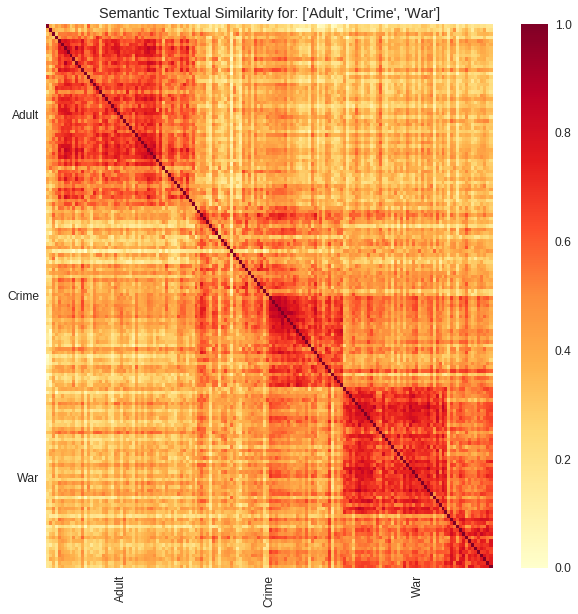

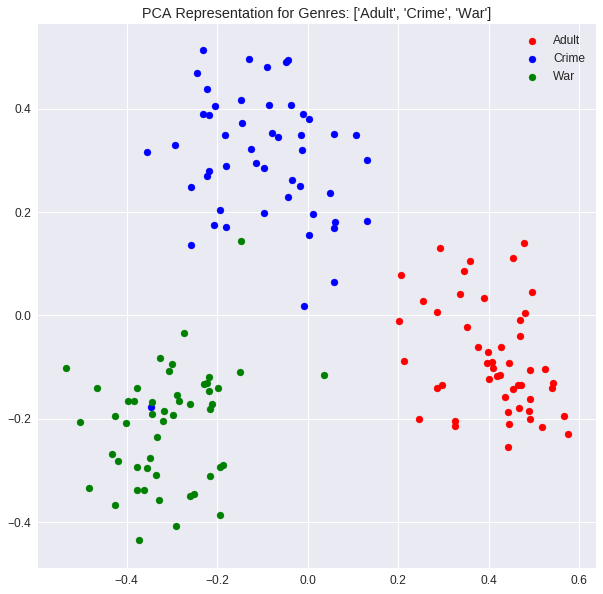

In [0]:
genre_list = ['Adult', 'Crime', 'War']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

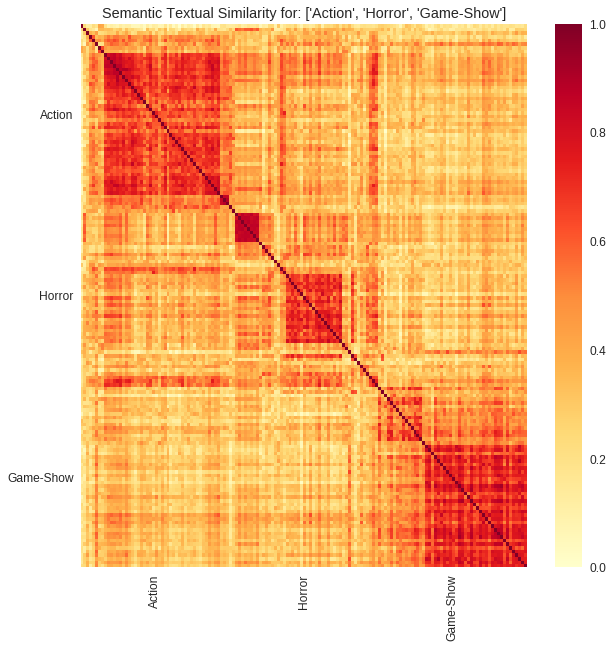

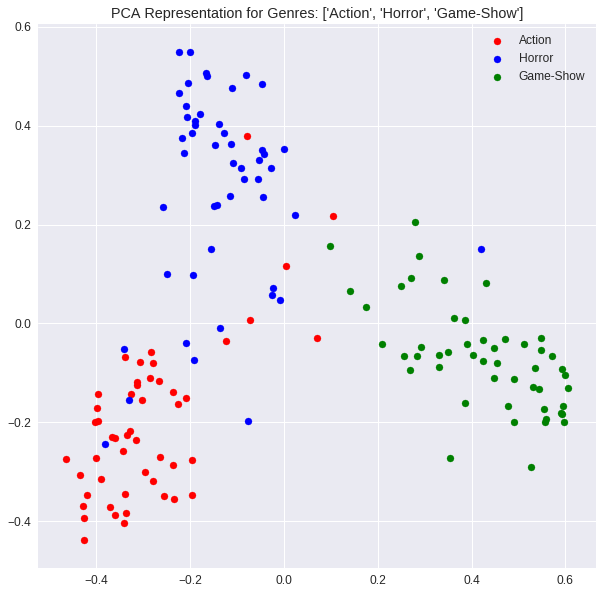

In [0]:
genre_list = [ 'Action', 'Horror', 'Game-Show']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

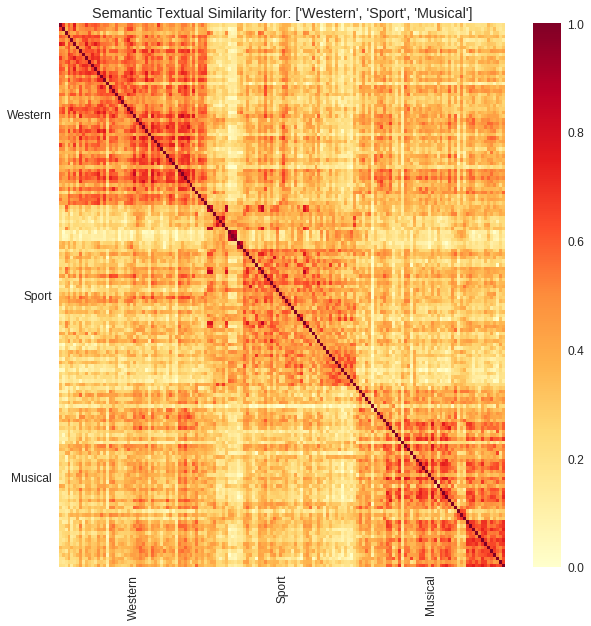

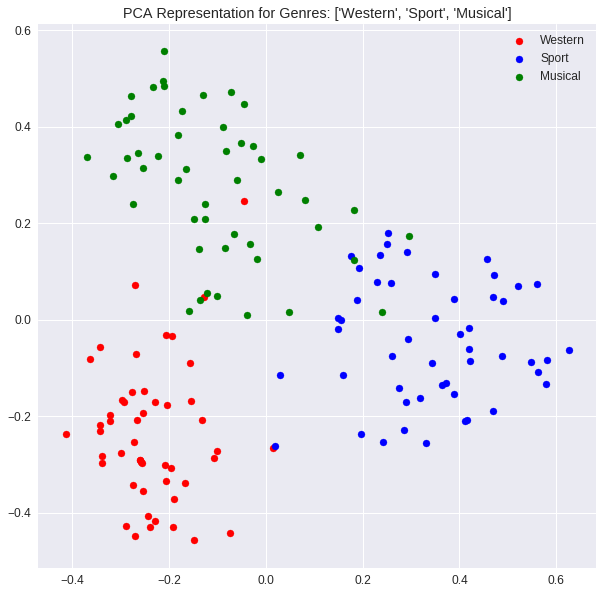

In [0]:
genre_list = ['Western', 'Sport', 'Musical']
plot_inp_set = []
genre_inp = []
for genre in genre_list:
    plot_inp_set.append(train_vector[train_y[genre]==1][:50])
    genre_inp+=[genre]*50

plot_inp=np.concatenate(plot_inp_set)
movie_genre_heatmap(plot_inp, genre_inp) 
movie_genre_scatter_plot(plot_inp, genre_inp)

## LabelPowerset + Logistic Regression

In [0]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) 
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)
num_clusters = cluster_center.shape[0]

In [0]:
#clf = LogisticRegression(C=10)
#clf.fit(train_vector, train_y_cluster_labels)
#predictions = multi_class_predict(clf, test_vector, cluster_center) 
#accuracy(test_y, predictions)

In [0]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

Using TensorFlow backend.


In [0]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(UniversalEmbedding, output_shape=(512, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(num_clusters, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0314 16:44:09.679253 140633690699648 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1505)              386785    
Total params: 518,113
Trainable params: 518,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_data=(test_text, test_label),
            epochs=10,
            batch_size=32)
  model.save_weights('./model.h5')